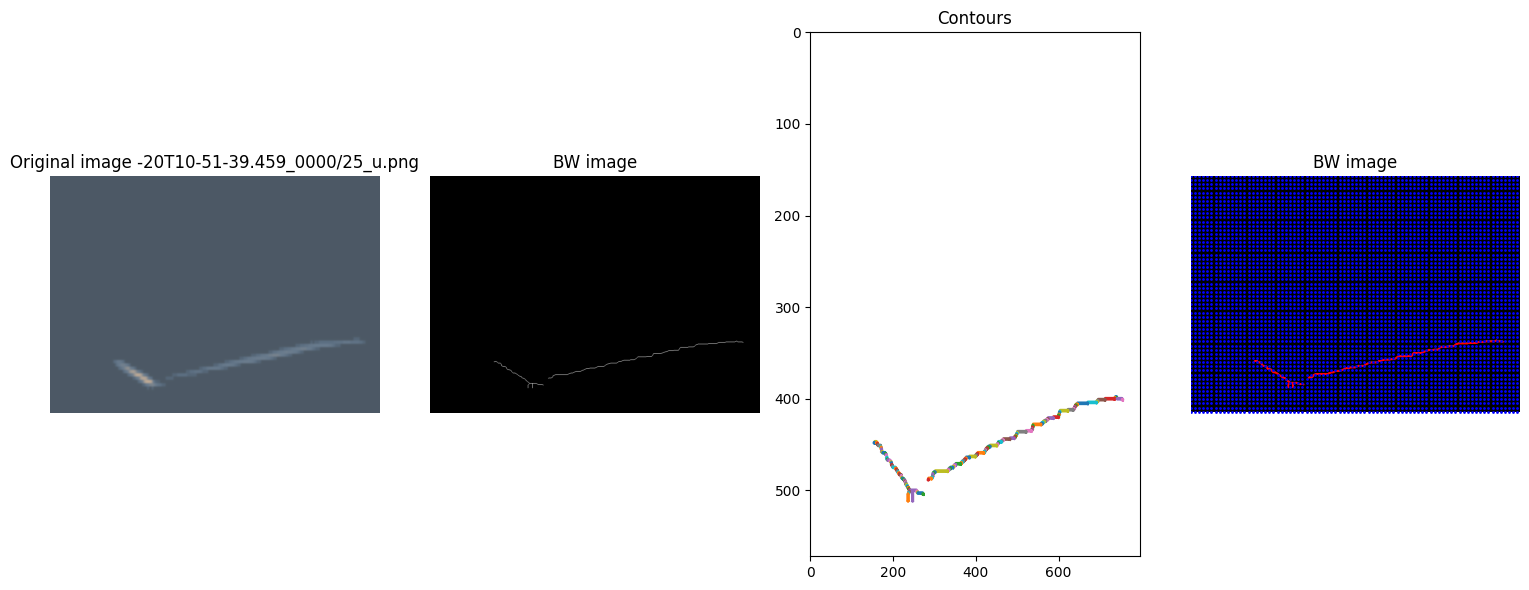

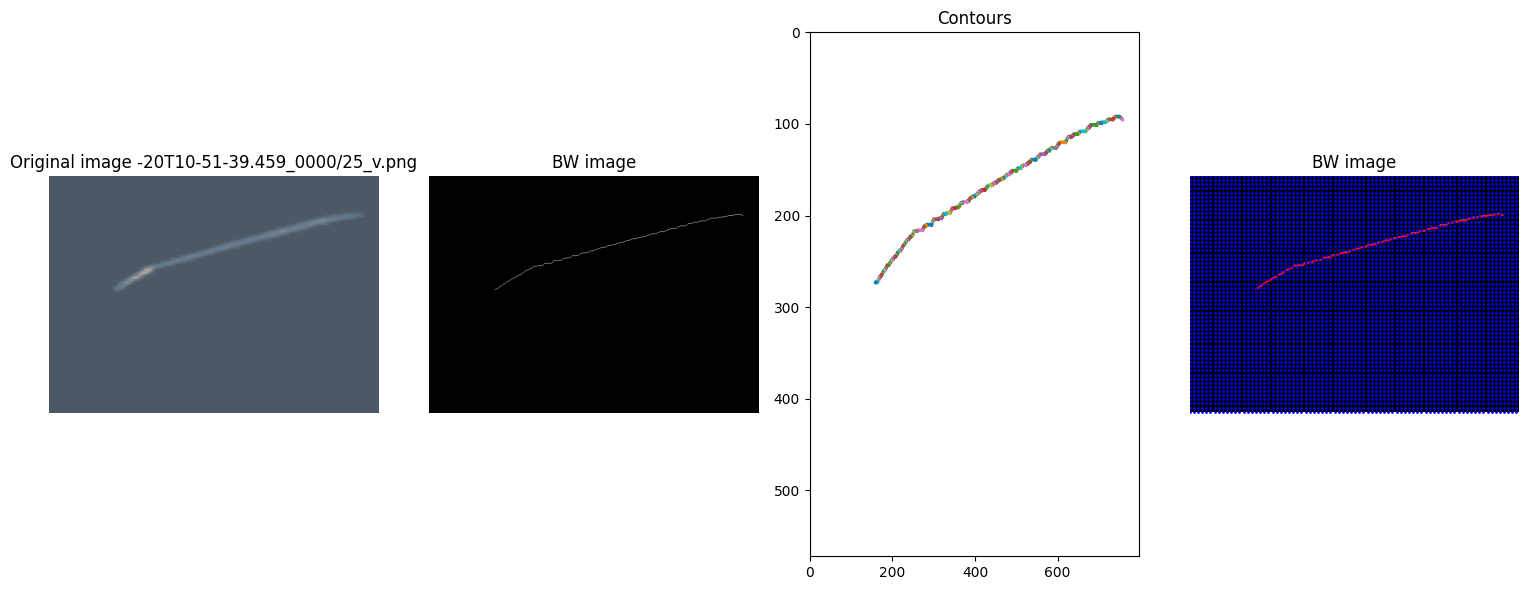

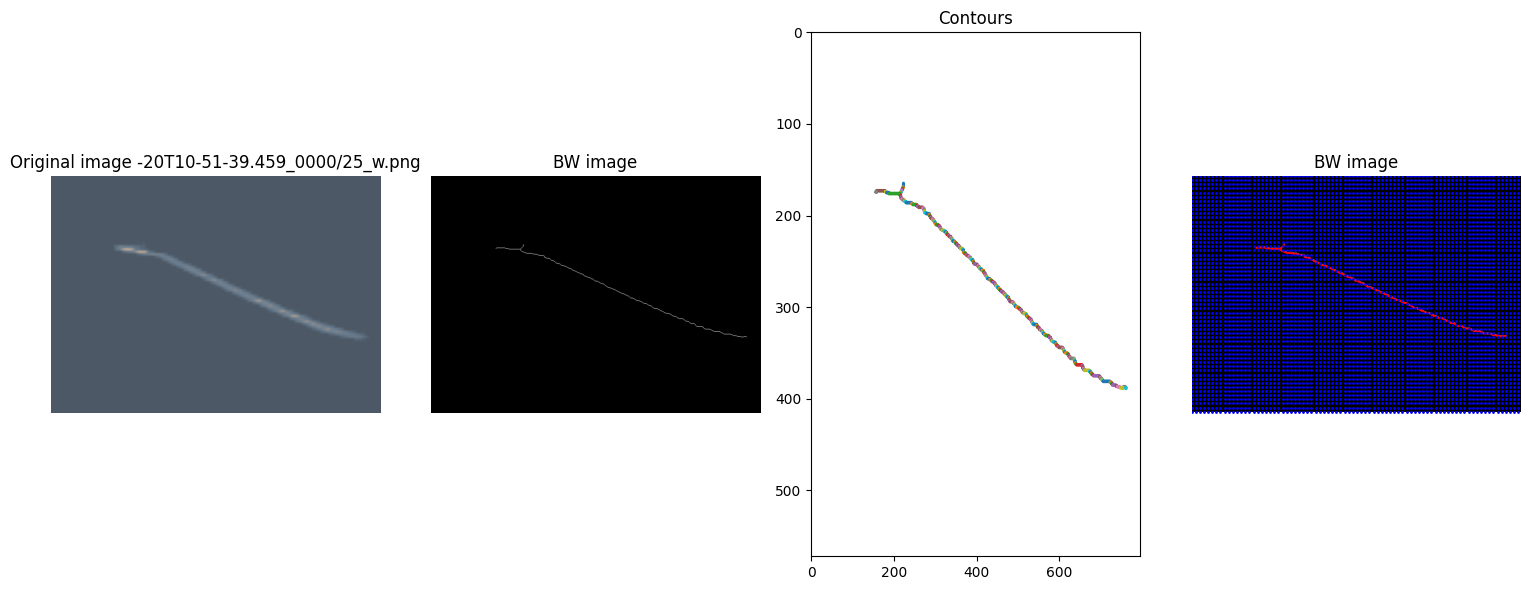

In [26]:
from skimage import measure
from matplotlib import cm
import numpy as np
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.morphology import skeletonize
from src.openImage import openImage
from skimage.transform import radon

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

from scipy.spatial import Delaunay,  ConvexHull

from matplotlib.path import Path


# Remove small shapes.
def cleanNoise(image, min_size_threshold=100):

    # Apply a different label for each shape.
    labeled_image, num_labels = ndimage.label(image)

    # Count the size of each labes which is the size of each shape. Remember to address the fact that 0 is not a real label and is background.
    sizes = np.bincount(labeled_image.ravel())

    # Exclude the background label (0) from the sizes array.
    sizes[0] = 0

    # Remove small connected components
    filtered_image = np.where(sizes[labeled_image] < min_size_threshold, 0, 1)

    return filtered_image

def computeMesh(image):

    contours = measure.find_contours(image, level=0.5)

    polygons = []

    for contour in contours:

        contour = np.column_stack((contour[:, 1], contour[:, 0]))

        polygon = Polygon(contour, closed=True, edgecolor='r', facecolor='none')
        polygons.append(polygon)

    return contours, polygons


def fitImage(path_and_name_input, path_and_name_output=None):

    ################### PARAMETERS TO BE CHANGED ###################

    white_th = 0.35#0.15
    gaussian_sigma = 1.75

    opt_skeleton = 1

    ##############################################################

    test_image = openImage(path_and_name_input)
    test_image.readImage()

    test_image.m_data = ndimage.gaussian_filter(test_image.m_data, gaussian_sigma)

    original_image = test_image.m_data


    # Black and white
    test_image.m_data = rgb2gray(test_image.m_data)

    grey_image = test_image.m_data

    # Turn completely black and white
    test_image.m_data = np.where(test_image.m_data < white_th, 0, 1)

    test_image.m_data = cleanNoise(test_image.m_data, 100)
    image_skeleton = skeletonize(test_image.m_data)

    if(opt_skeleton):
        test_image.m_data = image_skeleton

    # Create the canvas
    fig, axes = plt.subplots(1, 4, figsize=(15, 6))
    ax = axes.ravel()

    ax[0].imshow(original_image)
    ax[0].set_title('Original image ' + path_and_name_input[70:])
    ax[0].set_axis_off()

    ax[1].imshow(test_image.m_data, cmap=cm.gray)
    ax[1].set_title('BW image')
    ax[1].set_axis_off()

    contours, polygons = computeMesh(test_image.m_data)

    #contours = measure.find_contours(test_image.m_data, level=0.5)


    for contour in contours:
        ax[2].plot(contour[:, 1], contour[:, 0], linewidth=2)

    ax[2].set_title('Contours')
    ax[2].set_xlim(0,test_image.m_data.shape[1])
    ax[2].set_ylim(test_image.m_data.shape[0], 0)
    #ax[2].set_axis_off()




    ax[3].imshow(test_image.m_data, cmap=cm.gray)
    ax[3].set_title('BW image')
    ax[3].set_axis_off()
    p = PatchCollection(polygons, match_original=True)
    ax[3].add_collection(p)

    point_density = 10

    x_points, y_points = np.meshgrid(np.arange(0, test_image.m_data.shape[1], point_density),
                                 np.arange(0, test_image.m_data.shape[0], point_density))
    



    ax[3].scatter(x_points, y_points, color='blue', marker='o', s=1)
    #plt.scatter(x_within_contour, y_within_contour, color='blue', marker='o', s=1)

    ax[3].set_xlim(0,test_image.m_data.shape[1])
    ax[3].set_ylim(test_image.m_data.shape[0], 0)


    # Save the image
    plt.tight_layout()
    plt.savefig(path_and_name_output)










image_path = "/media/gant/Expansion/tpc_root_raw/DATA_ROOT/cleanimages2/"


""" image_list = ["CoBo_2018-06-20T10-51-39.459_0000/25",
              "CoBo_2018-06-20T10-51-39.459_0002/511",
              "CoBo_2018-06-20T10-51-39.459_0002/672",
              "CoBo_2018-06-20T10-51-39.459_0002/1019",
              "CoBo_2018-06-20T10-51-39.459_0003/1319",
              "CoBo_2018-06-20T10-51-39.459_0003/1428",
              "CoBo_2018-06-20T10-51-39.459_0004/114",
              "CoBo_2018-06-20T10-51-39.459_0004/319",
              "CoBo_2018-06-20T10-51-39.459_0004/417",
              "CoBo_2018-06-20T10-51-39.459_0004/448",
              "CoBo_2018-06-20T10-51-39.459_0004/1456",
              "CoBo_2018-06-20T10-51-39.459_0004/1596",
              "CoBo_2018-06-20T10-51-39.459_0004/1725",
              "CoBo_2018-06-20T10-51-39.459_0005/477",
              "CoBo_2018-06-20T10-51-39.459_0005/677",
              "CoBo_2018-06-20T10-51-39.459_0005/1113",
              "CoBo_2018-06-20T10-51-39.459_0005/1190",
              "CoBo_2018-06-20T10-51-39.459_0005/1311",
              "CoBo_2018-06-20T10-51-39.459_0005/1843"] """
image_list = ["CoBo_2018-06-20T10-51-39.459_0000/25"]

image_suffix_list = ["_u.png", "_v.png", "_w.png"]


output_path = "/media/gant/Expansion/tpc_root_raw/DATA_ROOT/fittedimages_radon/"


for image in image_list:
    for suffix in image_suffix_list:
        fitImage((image_path + image + suffix), (output_path + image + suffix))